In [561]:
import json
import requests
from sklearn.decomposition import PCA
from pandas.io.json import json_normalize
from datapackage import Package

In [1139]:
import numpy as np
import matplotlib.pyplot as plt

In [1073]:
import os
import time
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import string
import random
from IPython.core.display import display, HTML
import datetime

display(HTML("<style>.container { width:100% !important; }</style>"))

# (2020-05-05)

# An Exploratory Analysis of FDA Adverse Events Data

## Logistics

###### Prompt (Case Study for AZN):

The U.S. Food and Drug Administration (FDA) regulates over-the-counter and prescription drugs in the United States, including biological therapeutics and generic drugs. This work covers more than just medicines. For example, fluoride toothpaste, antiperspirants, dandruff shampoos and sunscreens are all considered drugs. 
 
An adverse event is submitted to the FDA to report any undesirable experience associated with the use of a medical product in a patient. For drugs, this includes serious drug side effects, product use errors, product quality problems, and therapeutic failures for prescription or over-the-counter medicines and medicines administered to hospital patients or at outpatient infusion centers. 
 
The FDA's database of adverse event reports is made available through a web API at https://open.fda.gov/apis/try-the-api/ Each report contains general information about the report, patient information, a list of the drugs that the patient is taking, and a list of the patient reactions.  It is possible to use these data in many ways: your brief is to explore these data and to see what might be learned from them.  As a guide, you might consider a practical solution to one of the following questions: 

- Are different adverse events reported in different countries? 
- What are the different adverse events associated with different disease areas? 
- What drugs tend to be taken together? 
 
You should publish your code to your personal github repository and send a link two days before interview.  At interview you should expect to discuss your code, any statistics or visualizations you may have used, limitations of the underlying data, and how your solution could be generalized, extended, and made into a robust product.

###### Things To Do:

- ✅ explore the data in FAERS
- ✅ code for connecting to the API, querying and fetching results
- ✅ GitHub repo: "fda_adverse_events" or maybe "azn_cs_faers" -> is it too cryptic?
- ✅ code for reading JSONs
- ✅ tackle 1st Q
- ⬜️ tackle 2nd Q
- ⬜️ tackle 3rd Q
- ⬜️ clean-up the notebook
- ⬜️ slidedeck
    - discuss code
    - explain stats & visualizations
    - discuss limitations of the data
    - explain findings
    - potential generalization, extension, and further development into a robust product
- ✅ email the GitHub repo
- ⬜️ rehearse presentation

## Some Key / Relevant Variables in FAERS for this Case Study (JSON Format)

![title](images/json.png)

- `meta`
- `results`
    - `safetyreportid` : The 8-digit Safety Report ID number, also known as the case report number or case ID. The first 7 digits (before the hyphen) identify an individual report and the last digit (after the hyphen) is a checksum. This field can be used to identify or find a specific adverse event report.
    - `receivedate` : **Date that the report was first received by FDA. If this report has multiple versions, this will be the date the first version was received by FDA. DATE (FDA USES THIS IN EXAMPLE REPORTS)**
    - `transmissiondate` : Date that the record was created. This may be earlier than the date the record was received by the FDA.
    - `receiptdate` : Date that the most recent information in the report was received by FDA.
    - `patient`
        - `patient.patientonsetage` : **Age of the patient when the event first occured. AGE OF PATIENT**
        - `patient.patientsex` :  The sex of the patient. Value is one of the following: 0. Unknown, 1. Male, 2. Female
        - `patient.reaction`
            - `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**
            - `patient.reaction.reactionoutcome` :  Outcome of the reaction in reactionmeddrapt at the time of last observation. Value is one of the following: 1. Recovered/resolved, 2. Recovering/resolving, 3. Not recovered/not resolved, 4. Recovered/resolved with sequelae (consequent health issues), 5. Fatal, 6. Unknown
        - `patient.drug`
            - `patient.drug.medicinalproduct` : Drug name. This may be the valid trade name of the product (such as ADVIL or ALEVE) or the generic name (such as IBUPROFEN). This field is not systematically normalized. It may contain misspellings or idiosyncratic descriptions of drugs, such as combination products such as those used for birth control.
            - `patient.drug.openfda.brand_name` : **Brand or trade name of the drug product. DRUG NAME**
            - `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.
            - `patient.drug.openfda.manufacturer_name` : **Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC DRUG MANUFACTURER**.
            - `patient.drug.drugadministrationroute` : The drug’s route of administration.
            - `patient.drug.openfda.route` : The route of administation of the drug product.
            - `patient.drug.drugindication` :  **Indication for the drug’s use. DRUG INDICATION / DISEASE AREA**
            - `patient.drug.openfda.pharm_class_epc` : Established pharmacologic class associated with an approved indication of an active moiety (generic drug) that the FDA has determined to be scientifically valid and clinically meaningful. Takes the form of the pharmacologic class, followed by [EPC] (such as Thiazide Diuretic [EPC] or Tumor Necrosis Factor Blocker [EPC]. DRUG CLASS**
    - `primarysource.reportercountry` : Country from which the report was submitted. *This one is in both country codes: https://datahub.io/core/country-list and in country names*
    - `occurcountry` : **The name of the country where the event occurred. *This one is in country codes.* COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**
    - `primarysourcecountry` : Country of the reporter of the event. *This one is also in country codes.*
    - `primarysource.qualification` : Category of individual who submitted the report. Value is one of the following: 1. Physician, 2. Pharmacist, 3. Other health professional, 4. Lawyer, 5. Consumer or non-health professional

###### Parsing the country codes:

In [907]:
package = Package('https://datahub.io/core/country-list/datapackage.json')
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        break

country_list = list(resource.read())
[i.reverse() for i in country_list]
country_name = dict(country_list)

In [908]:
country_name['TR']

'Turkey'

## Connecting to the openFDA API

###### OpenFDA API key: 
"WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

"With an API key: 240 requests per minute, per key. 120000 requests per day, per key."

![title](images/api_call.png)

In [673]:
api_key = "WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

In [674]:
query_start = "https://api.fda.gov/drug/event.json?api_key="+ api_key

In [648]:
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("https://api.fda.gov/drug/event.json?api_key="+ api_key+"&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [745]:
response = requests.get("https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20081231]&limit=1")
# Print the status code of the response.
print(response.status_code)

429


In [746]:
response.content

b'{\n  "error": {\n    "code": "OVER_RATE_LIMIT",\n    "message": "You have exceeded your rate limit. Try again later or contact us at https://api.fda.gov:443/contact/ for assistance"\n  }\n}'

## Parsing & Formatting JSON

###### From open.fda.gov:

![title](images/query_1_par.png)

![title](images/query_2_syn.png)

![title](images/query_3_adv_syn.png)

![title](images/query_4_dates_ranges.png)

In [1140]:
response = requests.get(query_start+"&search=receivedate:[20040101+TO+20081231]&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [1144]:
content = json.loads(response.content)
results = pd.json_normalize(data = content['results'])
results

,receiptdateformat,receiver,companynumb,receivedateformat,primarysource,seriousnessother,transmissiondateformat,fulfillexpeditecriteria,safetyreportid,receivedate,seriousnesshospitalization,transmissiondate,serious,receiptdate,sender.senderorganization,patient.patientonsetage,patient.reaction,patient.patientonsetageunit,patient.patientsex,patient.drug
0,102,None,HQWYE821915MAR04,102,None,1,102,1,4322505-4,20040319,1,20041129,1,20040315,FDA-Public Use,56,"[{'reactionmeddrapt': 'ARTHRALGIA'}, {'reactio...",801,1,"[{'drugstartdateformat': '102', 'drugindicatio..."


In [1147]:
results = pd.json_normalize(data = content['results'], record_path =['patient','reaction'])
results

,reactionmeddrapt
0,ARTHRALGIA
1,OEDEMA PERIPHERAL
2,PURPURA


In [1149]:
results = pd.json_normalize(data = content['results'], record_path =['patient','drug'])
results

,drugstartdateformat,drugindication,drugadministrationroute,drugtreatmentduration,drugcharacterization,drugstartdate,drugenddateformat,drugtreatmentdurationunit,drugdosagetext,drugauthorizationnumb,...,openfda.spl_set_id,openfda.brand_name,openfda.manufacturer_name,openfda.unii,openfda.rxcui,openfda.spl_id,openfda.substance_name,openfda.product_type,openfda.route,openfda.application_number
0,102,PYELONEPHRITIS,048,4,1,20031227,102,804,ORAL,50621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,"[8db221b1-32f3-f6ca-e404-71f56a860d08, 1d19a6d...","[OFLOXACIN OTIC, OFLOXACIN, OCUFLOX]","[Akorn, Inc., Dr. Reddy's Laboratories Limited...",[A4P49JAZ9H],"[207202, 312075, 198048, 198049, 198050, 242446]","[2d731281-5564-43ff-9889-07931fb2c555, 3e4a3dc...",[OFLOXACIN],[HUMAN PRESCRIPTION DRUG],"[AURICULAR (OTIC), ORAL, OPHTHALMIC]","[ANDA076407, NDA019921, ANDA091656, ANDA076128..."


In [1150]:
#this one works for counts, but would not work well with search only
def query(query_end):
    query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
    response = requests.get(query_start+query_end)
    content = json.loads(response.content)
    # print(json.dumps(parsed, indent=2, sort_keys=True))
    results = pd.json_normalize(content['results'])
    return results

In [752]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"")
results.head(10)

,reporttype,safetyreportversion,receivedateformat,transmissiondateformat,fulfillexpeditecriteria,safetyreportid,serious,receiptdate,receiptdateformat,seriousnessdeath,...,patient.patientonsetageunit,patient.patientweight,patient.patientsex,patient.drug,reportduplicate.duplicatesource,reportduplicate.duplicatenumb,receiver.receivertype,receiver.receiverorganization,sender.senderorganization,sender.sendertype
0,2,7,102,102,1,10005435,1,20140509,102,1,...,801,68.8,2,"[{'drugstartdateformat': '102', 'drugindicatio...",ROCHE,CA-ROCHE-1296647,6,FDA,FDA-Public Use,2


In [753]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"&count=occurcountry.exact")
results.head(10)

,term,count
0,CA,37725


In [946]:
query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
response = requests.get(query_start+'&count=patient.drug.openfda.brand_name.exact&limit=1100')
content = json.loads(response.content)

In [949]:
content

{'error': {'code': 'BAD_REQUEST',
  'message': 'Limit cannot exceed 1000 results for count requests.'}}

In [950]:
query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
response = requests.get(query_start+'&count=patient.drug.openfda.brand_name.exact&skip=1100')
content = json.loads(response.content)

In [951]:
content

{'error': {'code': 'BAD_REQUEST',
  'message': 'Should not use skip param when using count.'}}

Caveats:
- many layers to the JSON, individual reports need further flattening
- function is good enough for counts, which may be enough for this case study
- will use `skip` to paginate through the reports

## Exploration

###### Let's see how many times AstraZeneca pops up:

relevant field:
- `patient.drug.openfda.manufacturer_name` : <mark>Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC **DRUG MANUFACTURER**.</mark>

In [1152]:
top_manufacturers = query("&count=patient.drug.openfda.manufacturer_name.exact&limit=500")
top_manufacturers.head(10)

,term,count
0,Mylan Pharmaceuticals Inc.,2143943
1,Aurobindo Pharma Limited,1933948
2,"Teva Pharmaceuticals USA, Inc.",1749269
3,"Actavis Pharma, Inc.",1736623
4,Cadila Healthcare Limited,1723934
5,Amneal Pharmaceuticals LLC,1671581
6,Zydus Pharmaceuticals (USA) Inc.,1649009
7,"Sun Pharmaceutical Industries, Inc.",1545861
8,Sandoz Inc,1231388
9,West-Ward Pharmaceuticals Corp.,1201469


In [1153]:
top_manufacturers[top_manufacturers.term.str.contains('AstraZeneca')]

,term,count
146,AstraZeneca Pharmaceuticals LP,501107


**AstraZeneca is listed as a drug manufacturer in ~500K reports, and is not among the top 100 manufacturers in terms of frequency. (146th) Need to weigh this order by the size of the company somehow: e.g. volume of sales, revenue, income, etc.**

## Answering Specific Questions from the Case Study

###### 1. Are different adverse events reported in different countries? 

relevant fields:
- `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**
- `occurcountry` : **The name of the country where the event occurred. *This one is in country codes.* COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**


potential ways of answering the question:
- pick top X countries, and report top X adverse events for each
- construct a matrix of top X countries vs top Y adverse events, and visualize how similar countries are in this hyperspace, (maybe PCA before that), do clustering analysis, scrutinize outliers

In [1174]:
top_countries = query("&count=occurcountry.exact&limit=1000")
top_countries.head(10)

,term,count
0,US,6136862
1,GB,298758
2,CA,260177
3,JP,259359
4,FR,250505
5,DE,190403
6,IT,138001
7,BR,92823
8,ES,71442
9,AU,65305


In [1176]:
top_reactions = query("&count=patient.reaction.reactionmeddrapt.exact&limit=1000")
top_reactions.head(10)

,term,count
0,DRUG INEFFECTIVE,733191
1,NAUSEA,485098
2,DEATH,474541
3,FATIGUE,439328
4,HEADACHE,388310
5,DIARRHOEA,359872
6,DYSPNOEA,344540
7,PAIN,326354
8,OFF LABEL USE,324957
9,DIZZINESS,313617


**If I contstrain my analysis to top 100 reactions, what will I miss from each country? (top 25 reactions in each country scrutinized)**

In [1286]:
for i, country in enumerate(list(top_countries.term)[:50]):
    results = query("&search=occurcountry.exact:\""+country+"\"&count=patient.reaction.reactionmeddrapt.exact")
    for j, reaction in enumerate(list(results.term)[:25]):
        country_reaction_rank = j
        try:
            overall_reaction_rank = list(top_reactions.term).index(reaction)
        except:
            overall_reaction_rank = 1000
        if overall_reaction_rank>100:
            count = int(results[results.term == reaction]['count'])
            if count > 1000:
                print('country_rank:',i+1, country, 'country_reaction_rank:',country_reaction_rank+1, reaction,'count:',  count, 'overall_reaction_rank:', overall_reaction_rank+1)

country_rank: 2 GB country_reaction_rank: 9 LOWER RESPIRATORY TRACT INFECTION 9592 overall_reaction_rank: 311
country_rank: 3 CA country_reaction_rank: 8 RHEUMATOID ARTHRITIS 15270 overall_reaction_rank: 118
country_rank: 3 CA country_reaction_rank: 21 DRUG INTOLERANCE 9139 overall_reaction_rank: 148
country_rank: 3 CA country_reaction_rank: 24 ASTHMA 8819 overall_reaction_rank: 129
country_rank: 4 JP country_reaction_rank: 2 INTERSTITIAL LUNG DISEASE 8714 overall_reaction_rank: 264
country_rank: 4 JP country_reaction_rank: 4 PLATELET COUNT DECREASED 7650 overall_reaction_rank: 104
country_rank: 4 JP country_reaction_rank: 8 MALIGNANT NEOPLASM PROGRESSION 6974 overall_reaction_rank: 126
country_rank: 4 JP country_reaction_rank: 9 RENAL IMPAIRMENT 6706 overall_reaction_rank: 150
country_rank: 4 JP country_reaction_rank: 10 HEPATIC FUNCTION ABNORMAL 6672 overall_reaction_rank: 335
country_rank: 4 JP country_reaction_rank: 15 CEREBRAL INFARCTION 5506 overall_reaction_rank: 407
country_ran

In [1357]:
#presentation

In [1332]:
country_reactions = query("&search=occurcountry:\""+"HR"+"\"&count=patient.reaction.reactionmeddrapt.exact")
country_reactions.head(10)

,term,count
0,SUICIDE ATTEMPT,1005
1,INTENTIONAL OVERDOSE,830
2,SOMNOLENCE,492
3,DYSPNOEA,275
4,DRUG INTERACTION,259
5,NAUSEA,242
6,FATIGUE,215
7,PYREXIA,210
8,ASTHENIA,209
9,LOSS OF CONSCIOUSNESS,208


In [1334]:
country_reactions = query("&search=occurcountry:\""+"SE"+"\"&count=patient.reaction.reactionmeddrapt.exact")
country_reactions.head(10)

,term,count
0,INTENTIONAL OVERDOSE,4511
1,INTENTIONAL SELF-INJURY,4156
2,FATIGUE,2256
3,TOXICITY TO VARIOUS AGENTS,2044
4,NAUSEA,1257
5,DIZZINESS,1201
6,DEPRESSED LEVEL OF CONSCIOUSNESS,1113
7,DYSPNOEA,1026
8,TACHYCARDIA,978
9,HEADACHE,880


##### OK, I will read top 500 reactions in top 100 countries into a dataframe:

In [1358]:
m,n = 500,100
temp = np.zeros((m,n), dtype=np.int)

#for the top 100 drugs
for i, country in enumerate(list(top_countries.term)[:n]):
    reactions_for_country = query("&search=occurcountry.exact:\""+country+"\"&count=patient.reaction.reactionmeddrapt.exact&limit=1000")
    for j, reaction in enumerate(list(reactions_for_country.term)):
        country_reaction_rank = j
        try:
            overall_reaction_rank = list(top_reactions.term).index(reaction)
        except:
            overall_reaction_rank = 1000
        if overall_reaction_rank<m:
            temp[overall_reaction_rank,i] = reactions_for_country.loc[j]['count'] 

In [1482]:
temp.shape

(500, 100)

In [1404]:
top500_r_by_100_c = pd.DataFrame(temp,columns = list(top_countries.term)[:n],index = list(top_reactions.term)[:m])

In [1360]:
top500_r_by_100_c.to_pickle('./data/top500_reactions_by_100_countries.pickle')

In [1405]:
top500_r_by_100_c.iloc[:500, 0:25]

,US,GB,CA,JP,FR,DE,IT,BR,ES,AU,...,AR,TR,CH,PL,BE,PT,KR,MX,GR,TW
DRUG INEFFECTIVE,484075,6278,37725,4782,4820,4453,4668,7265,2266,2205,...,765,1032,749,1882,617,1170,519,648,891,324
NAUSEA,242231,11449,16993,6040,6760,7829,4146,3179,1394,1979,...,184,719,683,678,787,667,653,470,196,261
DEATH,226952,17448,18713,6515,4586,5622,2008,5495,1790,4852,...,2803,947,676,1105,1201,425,1052,2646,759,3311
FATIGUE,248898,12430,19856,1742,9701,7159,1324,3681,1050,1784,...,467,392,601,359,1041,713,188,616,356,264
HEADACHE,209207,10360,13249,2227,7506,4388,2479,4107,1045,1423,...,383,330,412,412,506,479,319,663,238,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INTENTIONAL SELF-INJURY,0,756,0,139,0,141,3548,0,35,137,...,0,0,14,15,0,0,0,9,0,0
BLOOD UREA INCREASED,2157,289,0,889,124,193,120,110,47,97,...,19,67,0,38,28,68,18,33,56,75
ECONOMIC PROBLEM,5751,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RETCHING,6984,281,237,0,0,163,314,453,0,38,...,0,0,0,18,0,0,8,0,14,0


Numbers are too small, beyond the 25th country, so constraining the analysis to top 25 countries:

In [1406]:
top500_r_by_100_c.iloc[:500, 25:50]

,IL,AT,DK,IE,RU,ZA,VE,CZ,NO,PR,...,HR,CL,TH,PH,PE,EG,MY,PK,HK,SK
DRUG INEFFECTIVE,600,521,389,466,841,408,122,617,314,752,...,193,273,100,72,110,185,115,62,102,211
NAUSEA,481,588,636,503,424,280,48,432,386,272,...,242,215,85,40,85,66,70,28,26,83
DEATH,705,823,308,1312,534,2399,3710,323,267,207,...,183,603,921,959,833,389,660,1755,1772,148
FATIGUE,424,503,846,532,156,260,100,409,391,389,...,215,184,154,25,61,191,47,44,19,108
HEADACHE,374,281,452,343,336,264,127,194,335,482,...,172,238,36,61,100,87,50,30,25,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INTENTIONAL SELF-INJURY,0,0,14,22,0,8,4,0,33,0,...,6,0,0,2,0,2,2,1,0,0
BLOOD UREA INCREASED,19,17,0,21,32,21,8,11,0,4,...,19,9,3,0,0,7,4,7,6,11
ECONOMIC PROBLEM,0,0,0,0,0,0,0,0,10,0,...,0,0,0,0,0,0,0,0,0,0
RETCHING,0,12,0,19,11,0,0,8,0,0,...,7,0,0,0,0,0,0,0,0,0


Scale each cell by total number of reports per country

In [1389]:
%%capture
df  = top500_r_by_100_c.iloc[:500, :25]
df=(df/df.sum())
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
#scaling like this is not what I want either, I want percentages
#df=(df-df.min())/(df.max()-df.min())

figure(num=None, figsize=(10, 100), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.tight_layout()
plt.savefig('./figures/top100_reactions_by_100_countries_heatmap.png')
#plt.show()

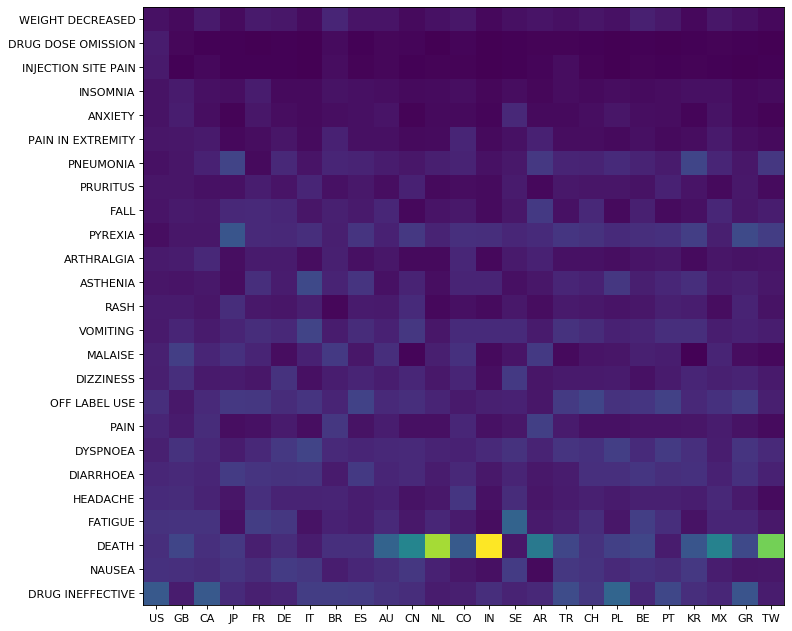

In [1407]:
df  = top500_r_by_100_c.iloc[:25, :25]
df=(df/df.sum())
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
#scaling like this is not what I want either, I want percentages
#df=(df-df.min())/(df.max()-df.min())

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.tight_layout()
#plt.savefig('./figures/top500_reactions_by_100_countries_heatmap.png')
plt.show()

Which countries are similar? Maybe we can reduce the dimensions, and visulize (+calculate) clusters.

In [1598]:
df  = top500_r_by_100_c.iloc[:500, :25]
df=(df/df.sum())

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.T)
#print(pca.components_)
print(pca.explained_variance_ratio_)

[0.47084302 0.11986394]


In [1599]:
first_eigenvector = np.array(pca.components_[0])
fe_indices = np.absolute(first_eigenvector).argsort()[-3:][::-1]
fe_indices

array([  2, 192, 495])

In [1600]:
first_eigenvector[fe_indices]

array([ 0.96418255, -0.07960804, -0.0783103 ])

In [1601]:
top_reactions.term[fe_indices]

2                        DEATH
192       INTENTIONAL OVERDOSE
495    INTENTIONAL SELF-INJURY
Name: term, dtype: object

In [1602]:
second_eigenvector = np.array(pca.components_[1])
se_indices = np.absolute(second_eigenvector).argsort()[-10:][::-1]
se_indices

array([192, 495,  62,  56,  10,   7,   0,   2, 288,  14])

In [1603]:
second_eigenvector[se_indices]

array([ 0.4771187 ,  0.43412035,  0.27250291,  0.20389749, -0.20175992,
       -0.19643319, -0.16991826,  0.12828156,  0.12386708, -0.11353995])

In [1604]:
top_reactions.term[se_indices]

192                INTENTIONAL OVERDOSE
495             INTENTIONAL SELF-INJURY
62           TOXICITY TO VARIOUS AGENTS
56                     DRUG INTERACTION
10                              MALAISE
7                                  PAIN
0                      DRUG INEFFECTIVE
2                                 DEATH
288    DEPRESSED LEVEL OF CONSCIOUSNESS
14                           ARTHRALGIA
Name: term, dtype: object

In [1605]:
df.shape

(500, 25)

In [1606]:
df_pca.shape

(25, 2)

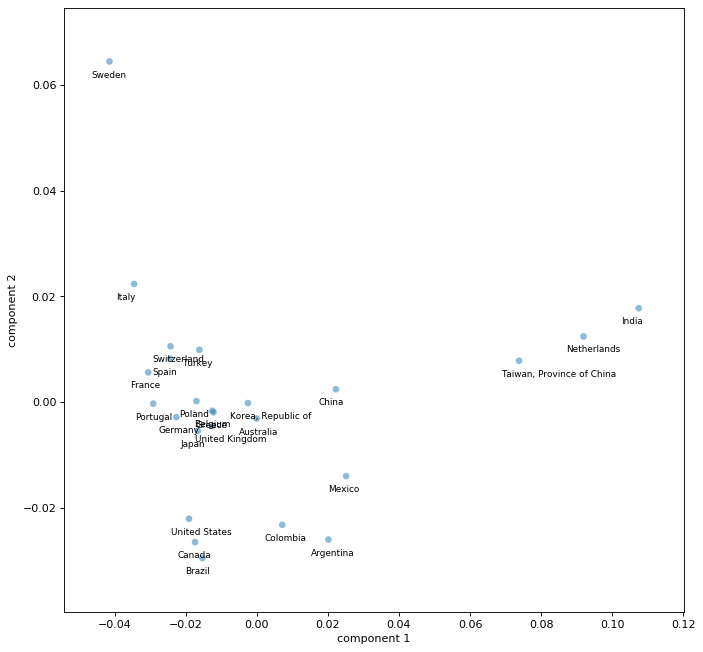

In [1607]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
v_c = 0.003
h_c = 0.005
for i, col in enumerate(df.columns):
    plt.annotate(country_name[col], (df_pca[i, 0]-h_c, df_pca[i, 1]-v_c),size=8)
plt.savefig('./figures/top500_reactions_by_100_countries_PCA.png')

How about top 25 reactions only:

In [1564]:
df  = top500_r_by_100_c.iloc[:25, :25]
df=(df/df.sum())

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.T)
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.10359912 -0.09391432  0.96853783 -0.09846119 -0.06565883 -0.06834358
  -0.04454542 -0.02271862 -0.07306069 -0.03819482 -0.04380066 -0.03206616
  -0.04287521 -0.04729986 -0.03407637  0.0128748  -0.01503109 -0.04863191
   0.01507499 -0.0130044  -0.03801952 -0.02083058 -0.0114146  -0.00989327
  -0.0310474 ]
 [-0.33659451 -0.10461498 -0.01901888  0.31271233  0.1674642  -0.14755561
  -0.16351978  0.27156944 -0.27449465  0.0871589   0.37811023 -0.1841767
  -0.15554374 -0.26839526  0.19363385 -0.33640263  0.20299618 -0.11518455
  -0.04469893  0.18197717  0.12426231  0.05472673  0.03359373  0.04505654
   0.09693861]]
[0.7013251  0.09147228]


In [1565]:
first_eigenvector = np.array(pca.components_[0])
fe_indices = np.absolute(first_eigenvector).argsort()[-5:][::-1]
fe_indices

array([2, 0, 3, 1, 8])

In [1566]:
first_eigenvector[fe_indices]

array([ 0.96853783, -0.10359912, -0.09846119, -0.09391432, -0.07306069])

In [1567]:
top_reactions.term[fe_indices]

2               DEATH
0    DRUG INEFFECTIVE
3             FATIGUE
1              NAUSEA
8       OFF LABEL USE
Name: term, dtype: object

In [1568]:
second_eigenvector = np.array(pca.components_[1])
se_indices = np.absolute(second_eigenvector).argsort()[-10:][::-1]
se_indices

array([10,  0, 15,  3,  8,  7, 13, 16, 14, 11])

In [1569]:
second_eigenvector[se_indices]

array([ 0.37811023, -0.33659451, -0.33640263,  0.31271233, -0.27449465,
        0.27156944, -0.26839526,  0.20299618,  0.19363385, -0.1841767 ])

In [1570]:
top_reactions.term[se_indices]

10             MALAISE
0     DRUG INEFFECTIVE
15             PYREXIA
3              FATIGUE
8        OFF LABEL USE
7                 PAIN
13            ASTHENIA
16                FALL
14          ARTHRALGIA
11            VOMITING
Name: term, dtype: object

In [1527]:
top_reactions.iloc[[0, 3, 8, 10, 13, 15]]

,term,count
0,DRUG INEFFECTIVE,733191
3,FATIGUE,439328
8,OFF LABEL USE,324957
10,MALAISE,292069
13,ASTHENIA,231802
15,PYREXIA,212052


In [1473]:
top_reactions.iloc[[0, 3, 8, 10, 13, 15]]

,term,count
0,DRUG INEFFECTIVE,733191
3,FATIGUE,439328
8,OFF LABEL USE,324957
10,MALAISE,292069
13,ASTHENIA,231802
15,PYREXIA,212052


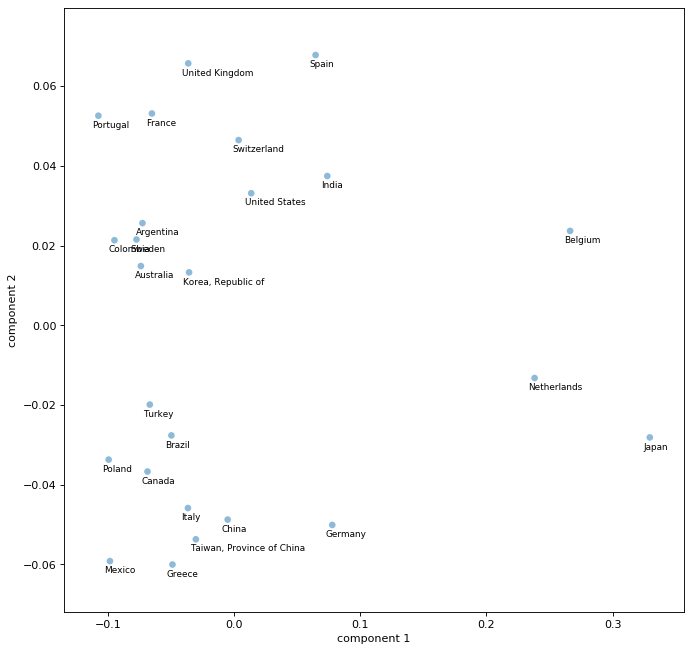

In [1483]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
v_c = 0.003
h_c = 0.005
for i, col in enumerate(df.columns):
    plt.annotate(country_name[col], (df_pca[i, 0]-h_c, df_pca[i, 1]-v_c),size=8)
plt.savefig('./figures/top25_reactions_by_countries_PCA.png')

In [1489]:
df  = top500_r_by_100_c.iloc[:25, :25]
df=(df/df.sum())

In [1490]:
country_cluster_1 = ['SE','GB','AR','BR','CO','AU','MX', 'FR','CA','US','DE','BE']
country_cluster_2 = ['CH','JP','PT','ES','IT','TR','GR','KR','PL','CN']
country_cluster_3 = ['IN','TW','NL']

In [1491]:
for country_code in country_cluster_1:
    print(country_name[country_code], end = ', ')

Sweden, United Kingdom, Argentina, Brazil, Colombia, Australia, Mexico, France, Canada, United States, Germany, Belgium, 

In [1492]:
df  = top500_r_by_100_c.iloc[:25, :25]
df=(df/df.sum())
#normalizing like this does not make much sense: 

In [1493]:
for country_code in country_cluster_2:
    print(country_name[country_code], end=', ')

Switzerland, Japan, Portugal, Spain, Italy, Turkey, Greece, Korea, Republic of, Poland, China, 

Rearranging columns of the dataframe based on clusters

In [1494]:
df = df[country_cluster_1+country_cluster_2+country_cluster_3]

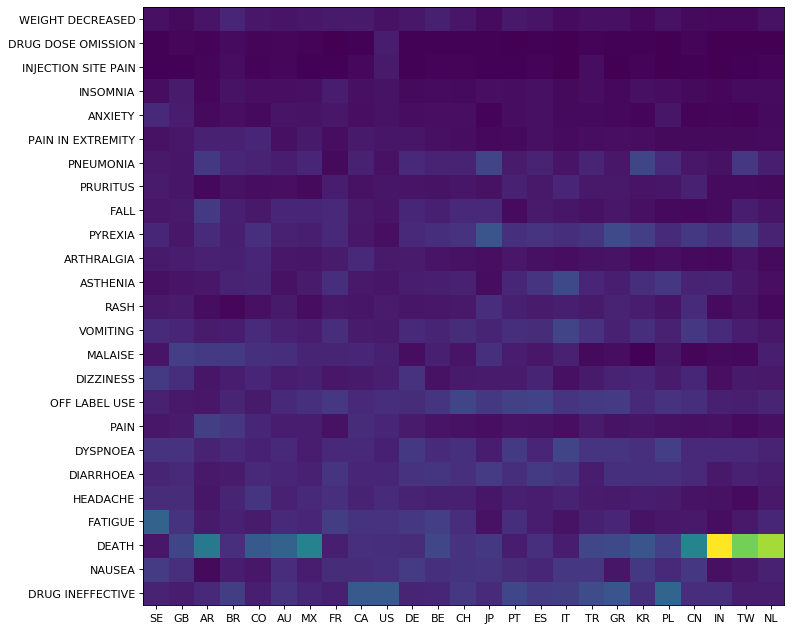

In [1495]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.tight_layout()
plt.savefig('./figures/top25_reactions_by_country_grouped_heatmap.png')
plt.show()

###### ANSWER:

Looks like YES, **different adverse events** are reported in **different countries**.

Furthermore:
- We see that certain countries have similar patterns in terms of drug reactions reported:
    - **Netherlands, Taiwan and India** cluster together because reports of Death seem to be very high from these countries.
    - **Sweden** looks like an outlier because of very high relative number of reports around suicide/self harm
    - The rest of the crowd is split into 2 clusters:
        - Cluster 1: Europe and Asia
        - Cluster 2: Americas
- When we do the PCA analysis, we see that the top 2 principal components that explain 59%=47+12% (79%=71+8%) of the variance in reported adverse event counts distribution and correspond mainly to the following drug reactions:
    - Death
    - Combination of INTENTIONAL OVERDOSE, INTENTIONAL SELF-INJURY, TOXICITY TO VARIOUS AGENTS, DRUG INTERACTION, MALAISE, PAIN, DRUG INEFFECTIVE

###### 2. What are the different adverse events associated with different disease areas?

Relevant fields:
- `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**          
- `patient.drug.drugindication` :  **Indication for the drug’s use. DRUG INDICATION / DISEASE AREA**

In [761]:
top_dis_areas = query("&count=patient.drug.drugindication.exact")
top_dis_areas.head(10)

,term,count
0,PRODUCT USED FOR UNKNOWN INDICATION,2694281
1,RHEUMATOID ARTHRITIS,612292
2,MULTIPLE SCLEROSIS,497499
3,HYPERTENSION,375888
4,PAIN,261658
5,PSORIASIS,259440
6,DIABETES MELLITUS,242301
7,DEPRESSION,224270
8,PLASMA CELL MYELOMA,217973
9,TYPE 2 DIABETES MELLITUS,205001


In [762]:
top_reactions = query("&count=patient.reaction.reactionmeddrapt.exact")
top_reactions.head(10)

,term,count
0,DRUG INEFFECTIVE,733191
1,NAUSEA,485098
2,DEATH,474541
3,FATIGUE,439328
4,HEADACHE,388310
5,DIARRHOEA,359872
6,DYSPNOEA,344540
7,PAIN,326354
8,OFF LABEL USE,324957
9,DIZZINESS,313617


In [765]:
results = query("&search=patient.drug.drugindication.exact:\"RHEUMATOID ARTHRITIS\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(10)

,term,count
0,DRUG INEFFECTIVE,66174
1,RHEUMATOID ARTHRITIS,46076
2,INJECTION SITE PAIN,44805
3,ARTHRALGIA,42584
4,PAIN,36150
5,INJECTION SITE ERYTHEMA,28149
6,PAIN IN EXTREMITY,26158
7,FATIGUE,25487
8,HEADACHE,23981
9,NAUSEA,20821


In [771]:
results = query("&search=patient.drug.drugindication.exact:\"MULTIPLE SCLEROSIS\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(10)

,term,count
0,FATIGUE,42655
1,MULTIPLE SCLEROSIS RELAPSE,40050
2,HEADACHE,26594
3,FALL,26252
4,GAIT DISTURBANCE,24487
5,MULTIPLE SCLEROSIS,21455
6,MEMORY IMPAIRMENT,20811
7,NAUSEA,19063
8,ASTHENIA,18711
9,PAIN,18430


In [779]:
print(results.head())

                      term  count
0  BLOOD GLUCOSE INCREASED  31242
1                   NAUSEA  15657
2         WEIGHT DECREASED  10524
3  BLOOD GLUCOSE DECREASED   8500
4                DIARRHOEA   8319


In [784]:
for i, d_a in enumerate(list(top_dis_areas.term)):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print(d_a)
    print(results.head(10))
    if i > 10: break

PRODUCT USED FOR UNKNOWN INDICATION
               term   count
0  DRUG INEFFECTIVE  172379
1             DEATH  125463
2           FATIGUE  102186
3            NAUSEA  101916
4         DIARRHOEA   87574
5          HEADACHE   84506
6          DYSPNOEA   78800
7           MALAISE   73939
8         DIZZINESS   70708
9              PAIN   67077
RHEUMATOID ARTHRITIS
                      term  count
0         DRUG INEFFECTIVE  66174
1     RHEUMATOID ARTHRITIS  46076
2      INJECTION SITE PAIN  44805
3               ARTHRALGIA  42584
4                     PAIN  36150
5  INJECTION SITE ERYTHEMA  28149
6        PAIN IN EXTREMITY  26158
7                  FATIGUE  25487
8                 HEADACHE  23981
9                   NAUSEA  20821
MULTIPLE SCLEROSIS
                         term  count
0                     FATIGUE  42655
1  MULTIPLE SCLEROSIS RELAPSE  40050
2                    HEADACHE  26594
3                        FALL  26252
4            GAIT DISTURBANCE  24487
5          MULTIPLE 

In [918]:
for i, d_a in enumerate(list(top_dis_areas.term)[:10]):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print('new disease area: ',d_a)
    for reaction in list(results.term)[:10]:
        if reaction not in list(top_reactions.term)[:25]:
            print(reaction)
    print()

new disease area:  PRODUCT USED FOR UNKNOWN INDICATION

new disease area:  RHEUMATOID ARTHRITIS
RHEUMATOID ARTHRITIS
INJECTION SITE ERYTHEMA

new disease area:  MULTIPLE SCLEROSIS
MULTIPLE SCLEROSIS RELAPSE
GAIT DISTURBANCE
MULTIPLE SCLEROSIS
MEMORY IMPAIRMENT

new disease area:  HYPERTENSION
HYPERTENSION
BLOOD PRESSURE INCREASED

new disease area:  PAIN
TOXICITY TO VARIOUS AGENTS
OVERDOSE

new disease area:  PSORIASIS
PSORIASIS
INJECTION SITE ERYTHEMA

new disease area:  DIABETES MELLITUS
MYOCARDIAL INFARCTION
CARDIAC FAILURE CONGESTIVE
BLOOD GLUCOSE INCREASED
CEREBROVASCULAR ACCIDENT
CORONARY ARTERY DISEASE
CARDIAC DISORDER

new disease area:  DEPRESSION
DEPRESSION
SUICIDAL IDEATION
FEELING ABNORMAL

new disease area:  PLASMA CELL MYELOMA
PLASMA CELL MYELOMA
NEUROPATHY PERIPHERAL
WHITE BLOOD CELL COUNT DECREASED

new disease area:  TYPE 2 DIABETES MELLITUS
BLOOD GLUCOSE INCREASED
BLOOD GLUCOSE DECREASED
BLADDER CANCER
DECREASED APPETITE



In [919]:
for i, d_a in enumerate(list(top_dis_areas.term)[:10]):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print('new disease area: ',d_a)
    for reaction in list(results.term)[:10]:
        if reaction in list(top_reactions.term)[:25]:
            print(reaction)
    print()

new disease area:  PRODUCT USED FOR UNKNOWN INDICATION
DRUG INEFFECTIVE
DEATH
FATIGUE
NAUSEA
DIARRHOEA
HEADACHE
DYSPNOEA
MALAISE
DIZZINESS
PAIN

new disease area:  RHEUMATOID ARTHRITIS
DRUG INEFFECTIVE
INJECTION SITE PAIN
ARTHRALGIA
PAIN
PAIN IN EXTREMITY
FATIGUE
HEADACHE
NAUSEA

new disease area:  MULTIPLE SCLEROSIS
FATIGUE
HEADACHE
FALL
NAUSEA
ASTHENIA
PAIN

new disease area:  HYPERTENSION
DRUG INEFFECTIVE
DIZZINESS
DYSPNOEA
NAUSEA
DIARRHOEA
FATIGUE
HEADACHE
FALL

new disease area:  PAIN
DRUG INEFFECTIVE
PAIN
NAUSEA
DEATH
FATIGUE
HEADACHE
VOMITING
DIZZINESS

new disease area:  PSORIASIS
DRUG INEFFECTIVE
INJECTION SITE PAIN
DIARRHOEA
HEADACHE
NAUSEA
ARTHRALGIA
FATIGUE
PRURITUS

new disease area:  DIABETES MELLITUS
DRUG INEFFECTIVE
NAUSEA
DIARRHOEA
DYSPNOEA

new disease area:  DEPRESSION
DRUG INEFFECTIVE
NAUSEA
ANXIETY
DIZZINESS
HEADACHE
FATIGUE
INSOMNIA

new disease area:  PLASMA CELL MYELOMA
PNEUMONIA
DEATH
FATIGUE
DIARRHOEA
RASH
ASTHENIA
NAUSEA

new disease area:  TYPE 2 DIABETES ME

###### ANSWER:

###### 3. What drugs tend to be taken together?  

Relevant fields:
- `patient.drug.openfda.brand_name` : **Brand or trade name of the drug product. DRUG NAME**
- `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.

In [991]:
top_drugs = query("&count=patient.drug.openfda.brand_name.exact&limit=1000")
top_drugs.head(25)

,term,count
0,ENBREL,505631
1,HUMIRA,459208
2,ECOTRIN,331225
3,ASPIRIN 325,330143
4,BAYER LOW DOSE,328604
5,BUFFERIN,326761
6,LOW DOSE ASPIRIN,326321
7,LOW DOSE ASPIRIN ENTERIC SAFETY COATED,326321
8,LOW DOSE ASPIRIN LOW DOSE,326321
9,ASPIRIN LOW DOSE,326235


In [985]:
top_drugs[top_drugs.term.str.contains('ASPIRIN')]

,term,count
3,ASPIRIN 325,330143
6,LOW DOSE ASPIRIN,326321
7,LOW DOSE ASPIRIN ENTERIC SAFETY COATED,326321
8,LOW DOSE ASPIRIN LOW DOSE,326321
9,ASPIRIN LOW DOSE,326235
...,...,...
632,MOORE MEDICAL EXTRA STRENGTH NON ASPIRIN,90680
633,MOORE MEDICAL NON ASPIRIN,90680
649,PHYSICIANSCARE NON ASPIRIN EXTRA STRENGTH,90680
661,SHOPRITE NON-ASPIRIN,90680


In [1081]:
top_drugs = query("&count=patient.drug.openfda.generic_name.exact&limit=1000")
top_drugs.head(10)

,term,count
0,ETANERCEPT,505631
1,ADALIMUMAB,459208
2,ASPIRIN,346100
3,ASPIRIN 81 MG,325826
4,ASPIRIN 325 MG,325744
5,ASPIRIN 81MG,319627
6,METHOTREXATE SODIUM,290720
7,FUROSEMIDE,260480
8,METHOTREXATE,249580
9,PREDNISONE,244889


In [987]:
top_drugs[top_drugs.term.str.contains('ASPIRIN')]

,term,count
2,ASPIRIN,346100
3,ASPIRIN 81 MG,325826
4,ASPIRIN 325 MG,325744
5,ASPIRIN 81MG,319627
490,"ACETAMINOPHEN, ASPIRIN (NSAID) AND CAFFEINE",11674
668,"ACETAMINOPHEN, ASPIRIN, AND CAFFEINE",6390
725,"ACETAMINOPHEN, ASPIRIN (NSAID), AND CAFFEINE",5519
771,ASPIRIN AND DIPYRIDAMOLE,4924
911,BAYER ASPIRIN EXTRA STRENGTH,3329


**Argument for using the generic name instead of brand name of a drug!**

In [1003]:
HUMIRA = query("&search=patient.drug.openfda.brand_name.exact:\"HUMIRA\"&count=patient.drug.openfda.brand_name.exact&limit=1000")
HUMIRA.head(25)

,term,count
0,HUMIRA,459208
1,METHOTREXATE,75898
2,TREXALL,69092
3,XATMEP,69039
4,PREDNISONE,35482
5,ENBREL,34246
6,FOLIC ACID,33914
7,VITAMIN D,17236
8,ACID REDUCER,15626
9,ORENCIA,13826


In [1010]:
ADALIMUMAB = query("&search=patient.drug.openfda.generic_name.exact:\"ADALIMUMAB\"&count=patient.drug.openfda.generic_name.exact&limit=10")
ADALIMUMAB.head(25)

,term,count
0,ADALIMUMAB,459208
1,METHOTREXATE SODIUM,75898
2,METHOTREXATE,69092
3,PREDNISONE,35482
4,ETANERCEPT,34246
5,FOLIC ACID,33914
6,ERGOCALCIFEROL,17252
7,SULFASALAZINE,13859
8,ABATACEPT,13826
9,OMEPRAZOLE,12775


In [1012]:
ADALIMUMAB.tail()

,term,count
5,FOLIC ACID,33914
6,ERGOCALCIFEROL,17252
7,SULFASALAZINE,13859
8,ABATACEPT,13826
9,OMEPRAZOLE,12775


In [1014]:
for co_drug in list(ADALIMUMAB.term):
    print(list(top_drugs.term)[:100].index(co_drug))

3
1
2
4
0
5
14
7
6
16


In [1088]:
list(top_drugs.term).index('GOLD')

ValueError: 'GOLD' is not in list

In [1124]:
m,n = 100,100
temp = np.zeros((m,n), dtype=np.int)

#for the top 100 drugs
for i, drug in enumerate(list(top_drugs.term)[:100]):
    co_drugs = query("&search=patient.drug.openfda.generic_name.exact:\""+drug+"\"&count=patient.drug.openfda.generic_name.exact&limit=1000")
    for j, co_drug in enumerate(list(co_drugs.term)):
        co_drug_rank = j
        try:
            overall_drug_rank = list(top_drugs.term).index(co_drug)
        except:
            overall_drug_rank = 1000
        if((overall_drug_rank+1)/(co_drug_rank+1)>50) & (drug!=co_drug) :
            print(i,drug, co_drug_rank, co_drug, overall_drug_rank)
        if overall_drug_rank<100:
            temp[i,overall_drug_rank] = co_drugs.loc[j]['count'] 
    #if i>1: break

15 LEVOTHYROXINE SODIUM 1 LEVOTHYROXINE SODIUM ANHYDROUS 133
23 METOPROLOL TARTRATE 2 METOROPROLOL TARTRATE 171
28 METOPROLOL 2 METOROPROLOL TARTRATE 171
32 CLOPIDOGREL BISULFATE 1 CLOPIDOGREL 153
39 DULOXETINE HYDROCHLORIDE 1 DULOXETINE 288
40 SERTRALINE HYDROCHLORIDE 1 SERTRALINE 147
41 LANSOPRAZOLE 1 LANSOPRAZOLE DELAYED RELEASE 123
53 ADAPALENE 2 SALICYLIC ACID 253
53 ADAPALENE 3 SULFUR 648
53 ADAPALENE 4 BENZOYL PEROXIDE 899
53 ADAPALENE 8 HYDROQUINONE 1000
59 CITALOPRAM 1 CITALOPRAM HYDROBROMIDE 103
63 ONDANSETRON HYDROCHLORIDE 1 ONDANSETRON 152
63 ONDANSETRON HYDROCHLORIDE 2 ONDANSETRON TABLETS 165
65 AMBRISENTAN 1 TADALAFIL 119
67 RANITIDINE HYDROCHLORIDE 1 RANITIDINE 131
74 NAPROXEN SODIUM 1 NAPROXEN 148
74 NAPROXEN SODIUM 2 NAPROXEN SODIUM 220 MG 173
75 SILDENAFIL CITRATE 1 SILDENAFIL 275
75 SILDENAFIL CITRATE 2 SILDINAFIL 360
80 VENLAFAXINE HYDROCHLORIDE 1 VENLAFAXINE 238
81 LAMOTRIGINE 1 LAMOTRIGINE CHEWABLE DISPERSIBLE 210
83 FLUOXETINE HYDROCHLORIDE 1 FLUOXETINE 193
84 ES

In [1132]:
top100_drug_by_drug = pd.DataFrame(temp,columns = list(top_drugs.term)[:n],index = list(top_drugs.term)[:m])

In [1133]:
top100_drug_by_drug

,ETANERCEPT,ADALIMUMAB,ASPIRIN,ASPIRIN 81 MG,ASPIRIN 325 MG,ASPIRIN 81MG,METHOTREXATE SODIUM,FUROSEMIDE,METHOTREXATE,PREDNISONE,...,GLYCERIN,"AVOBENZONE, OCTISALATE, AND OCTOCRYLENE",VALSARTAN,HYDROCODONE BITARTRATE AND ACETAMINOPHEN,DIMETHICONE,DIPHENHYDRAMINE HYDROCHLORIDE,EXENATIDE,TACROLIMUS,"ACETAMINOPHEN, GUAIFENESIN, AND PHENYLEPHRINE HYDROCHLORIDE",ALBUTEROL
ETANERCEPT,505631,34246,4006,3695,3693,3459,82490,2585,74042,21439,...,1681,0,1245,1510,1657,1067,140,1118,2346,751
ADALIMUMAB,34246,459208,11458,11181,11177,11126,75898,6183,69092,35482,...,6246,0,2807,3008,6200,2153,218,668,3707,2830
ASPIRIN,4006,11458,346100,325766,325744,319627,8608,48863,8105,16752,...,13730,0,11514,8306,13427,7026,4965,2996,9668,11258
ASPIRIN 81 MG,3695,11181,325766,325826,325744,319299,8203,46092,7758,15779,...,12424,0,10871,7625,12146,6606,4787,2841,8868,10649
ASPIRIN 325 MG,3693,11177,325744,325744,325744,319299,8202,46086,7757,15773,...,12420,0,10871,7624,12142,6605,4787,2840,8865,10646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DIPHENHYDRAMINE HYDROCHLORIDE,1067,2153,7026,6606,6605,6518,3083,5984,2836,9169,...,3451,102,993,2809,3370,75959,209,807,9265,3940
EXENATIDE,140,218,4965,4787,4787,4614,220,2436,211,509,...,491,0,1015,352,485,209,75081,38,250,473
TACROLIMUS,1118,668,2996,2841,2840,2780,4422,3599,4214,15681,...,457,0,536,307,406,807,38,74845,534,402
"ACETAMINOPHEN, GUAIFENESIN, AND PHENYLEPHRINE HYDROCHLORIDE",2346,3707,9668,8868,8865,8754,4303,7441,3831,7690,...,4617,147,1342,2573,4491,9265,250,534,74170,2837


In [1134]:
df  = top100_drug_by_drug

In [1136]:
df=(df-df.min())/(df.max()-df.min())

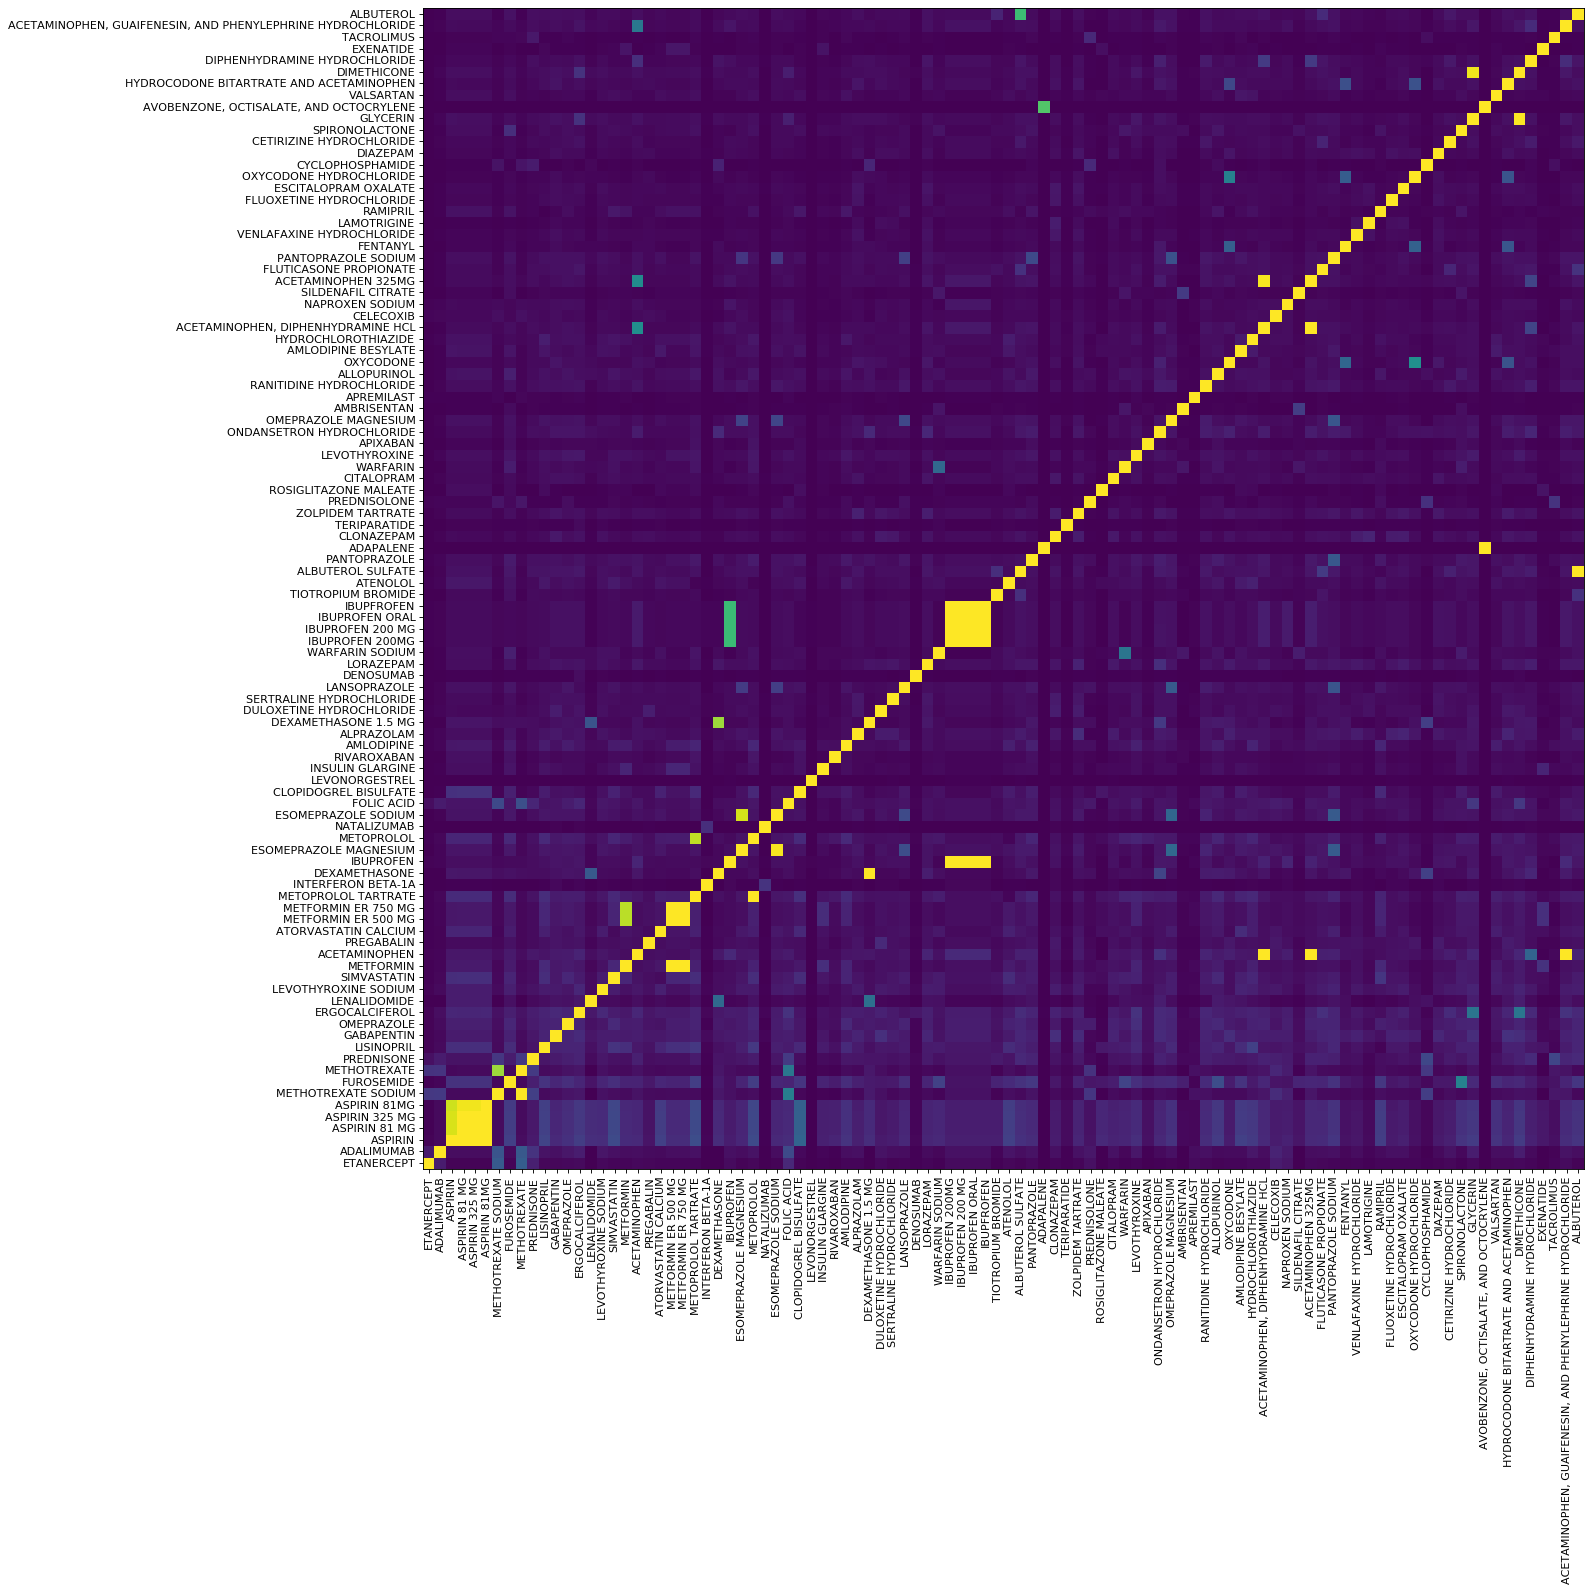

In [1138]:
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
plt.tight_layout()
plt.savefig('./figures/top100_drug_by_drug_heatmap.png')
plt.show()

###### IDEA: Use drug-drug interaction databases to see if high frequency pairs are shown to interact or not.

###### ANSWER:

## Discussion & Future Directions

###### Limitations of the Data

* reporting biases
    * e.g. so many instances of Aspirin

* ~250 calls / minute with an API key (limitation of the interface)
* typos, etc. in documentation (e.g. count returns 100 instead of 1000) 
>`count: Count the number of unique values of a certain field, for all the records that matched the search parameter. By default, the API returns the 1000 most frequent values.`
*

###### Potential Future Directions